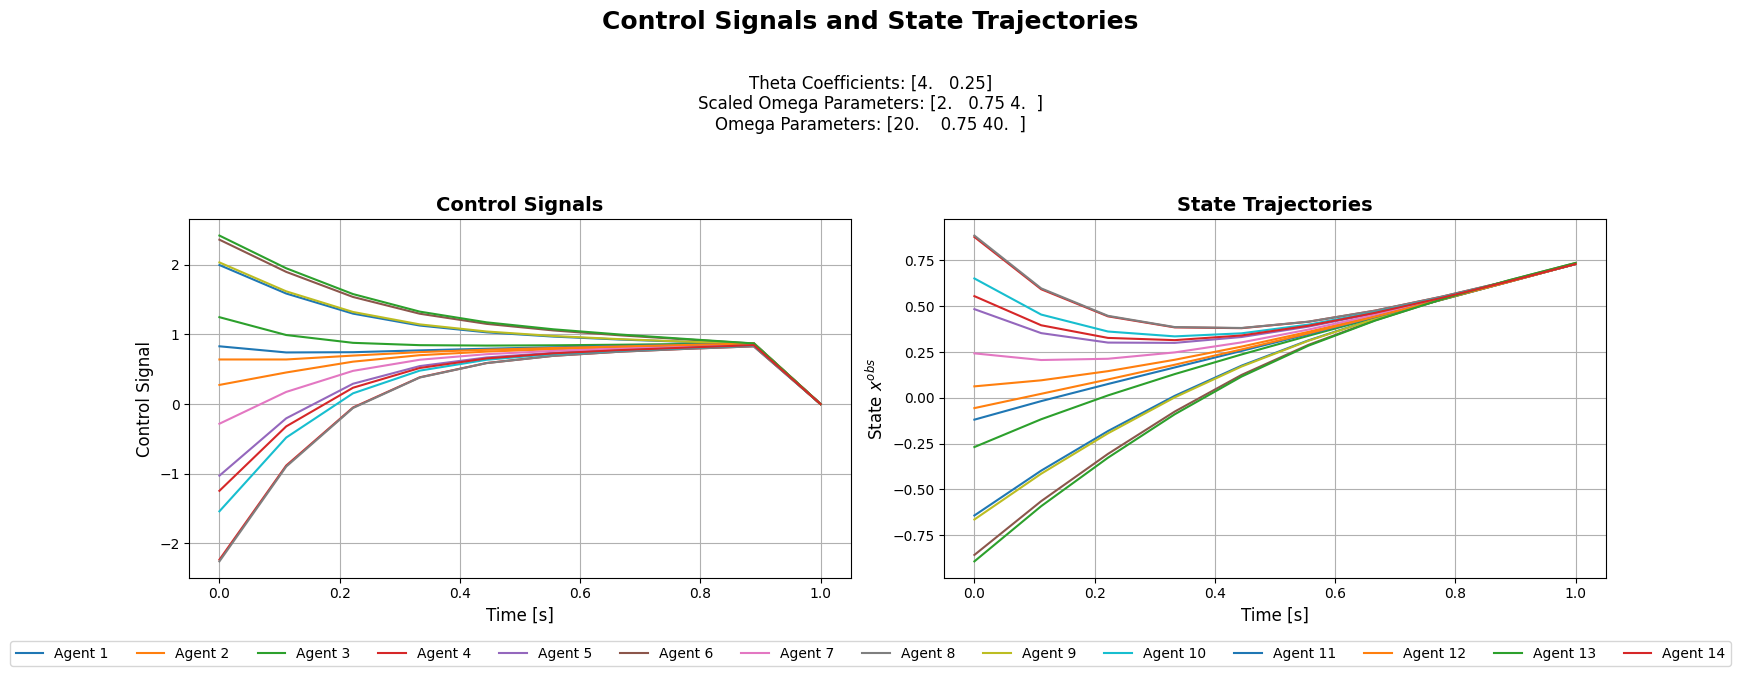

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit
import optax  
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from mpl_toolkits.mplot3d import Axes3D

seed = 45
key = jax.random.PRNGKey(seed)

# Parameters
n_agents = 14
n_steps = 10
true_theta = jnp.array([4, 0.25])
# parameters gamma (describes the x - discrepancy), tau, nu
true_Omega_parameters = jnp.array([20, 0.75, 40])
T = 1

K_channels = n_agents  # can be changed to test the effect of media - type controls. In this project always equal to n_agents
t = jnp.linspace(0, T, n_steps)  # Time grid
dt = t[1] - t[0]

@jit
def func(positions, controls, theta):
    """
    Compute the forces acting on each particle given their positions, parameters (theta = (alpha, c)), and control values.

    Args:
        positions (list of float): A list of length N representing the positions of the particles at time t.
        theta (float): Parameters [alpha, c] of the CS kernel.
        controls (list of float): A list of length N representing the control values at time t.

    Returns:
        list of float: A list of length N representing the forces acting on each particle at time t.
    """
    alpha = theta[0]
    c = theta[1]

    def pairwise_forces(i, positions, c, alpha):
        distances = positions - positions[i]
        forces = (distances * c) / ((jnp.abs(distances) ** 2 + 1) ** alpha)
        forces = forces.at[i].set(0)  # Set force on itself to 0
        return jnp.sum(forces, axis=0)

    forces = jax.vmap(pairwise_forces, in_axes=(0, None, None, None))(jnp.arange(positions.shape[0]), positions, c, alpha)

    forces += controls
    return forces
@jit
def rk4_step(x, u, dt, theta_coefficients):
    """Computes the next positions of the particles using the Runge-Kutta 4th order method

    Args:
        x (list of float): A list of length N representing the positions of the particles at time t.
        u (list of float): A list of length N representing the control values at time t.
        dt (float): time step
        theta_coefficients (float, float): Parameters [alpha, c] of the CS kernel.

    Returns:
        (list of float): A list of length N representing the positions of the particles at time t + dt.
    """
    k1 = dt * func(x, u, theta_coefficients)
    k2 = dt * func(x + 0.5 * k1, u, theta_coefficients)
    k3 = dt * func(x + 0.5 * k2, u, theta_coefficients)
    k4 = dt * func(x + k3, u, theta_coefficients)
    return x + (k1 + 2*k2 + 2*k3 + k4) / 6

@jit
def forward_pass(x_0, u_grid, theta_coefficients):
    """Computes the positions of the particles at each time step using the Runge-Kutta 4th order method

    Args:
        x_0 (float of len N): initial postinions of the particles
        u_grid (float of dim N x (K+1)): control values at each time step and for each particle
        theta_coefficients (float, float): parameters of the CS kernel

    Returns:
        x_grid (float of dim N x (K+1)): positions of the particles at each time step
    """
    x_grid = jnp.zeros((n_agents, n_steps))
    x_grid = x_grid.at[:, 0].set(x_0)
    for i in range(1, n_steps):
        x = x_grid[:, i-1]
        u = u_grid[:, i-1]
        x_grid = x_grid.at[:, i].set(rk4_step(x, u, dt, theta_coefficients))
    return x_grid

def compute_J(x_grid, u_grid, theta_coefficients, Omega_parameters):
    """Computes the cost function J_Omega for a given trajectory, and parameters Omega

    Args:
        x_grid (float of dim N x (K+1)): positions of the particles at each time step
        u_grid (float of dim N x (K+1)): control values at each time step and for each particle
        theta_coefficients (float, float): parameters of the CS kernel
        Omega_parameters (float, float, float): scaled down parameters of the loss function

    Returns:
        float: the value of the cost functional J_Omega
    """
    
    # Rescale Omega parameters
    rescaled_Omega_parameters = jnp.array([10, 1, 10]) * Omega_parameters
    gamma, x_hat, nu = rescaled_Omega_parameters

    # Compute the running cost J
    x_means = jnp.mean(x_grid[:, :n_steps], axis=0)
    x_diffs = x_grid[:, :n_steps] - x_means
    u_squares = jnp.square(u_grid[:, :n_steps])

    running_j = dt * jnp.sum(gamma * jnp.sum(jnp.square(x_diffs), axis=0) + jnp.sum(u_squares, axis=0))

    # Handle the final step separately to compute the terminal cost
    x_final = x_grid[:, n_steps - 1]
    phi = nu * jnp.dot(x_final - x_hat, x_final - x_hat)

    # Compute the final cost J
    J = running_j + phi
    return J

@jit
def compute_loss(u, x_0, theta_coefficients, Omega_parameters):
    """calls on the forward pass and compute_J functions to compute the loss function

    Args:
        u (float vector): control values before reshaping into a matrix
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float, float): parameters of the CS kernel
        Omega_parameters (float, float, float): scaled down parameters of the loss function

    Returns:
        float: the value of the cost functional J_Omega
    """
    u_grid = u.reshape((K_channels, n_steps))
    x_grid = forward_pass(x_0, u_grid, theta_coefficients)
    return compute_J(x_grid, u_grid, theta_coefficients, Omega_parameters)

def run_optimization(x_0, theta_coefficients, Omega_parameters):
    """finds the optimal control signal u

    Args:
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float, float): parameters of the CS kernel
        Omega_parameters (float, float, float): scaled down parameters of the loss function J

    Returns:
        u (float vector): control values before reshaping into a matrix
    """
    optimizer = optax.adam(learning_rate=0.05)
    gradient_u = lambda u: grad(compute_loss, argnums=0)(u, x_0, theta_coefficients, Omega_parameters)

    @partial(jit, static_argnums=(2,))
    def update_step(u, opt_state, n_agents):
        grads = gradient_u(u)
        updates, opt_state = optimizer.update(grads, opt_state)
        u = optax.apply_updates(u, updates)
        return u, opt_state

    u_init = jnp.zeros(K_channels * n_steps)
    opt_state = optimizer.init(u_init)
    u = u_init
    last_loss_values = []
    for i in range(50):  # Number of optimization steps
        u, opt_state = update_step(u, opt_state, n_agents)
        if i > 40:  # check convergence
            last_loss_values.append(compute_loss(u, x_0, theta_coefficients, Omega_parameters))

    have_converged = (max(last_loss_values) - min(last_loss_values)) / min(last_loss_values)
    while have_converged > 0.001:
        last_loss_values = []
        for i in range(20):  # Number of optimization steps
            u, opt_state = update_step(u, opt_state, n_agents)
            if i > 15:  # check convergence
                last_loss_values.append(compute_loss(u, x_0, theta_coefficients, Omega_parameters))
        have_converged = (max(last_loss_values) - min(last_loss_values)) / min(last_loss_values)
    return u

def find_u_grid(n_agents, n_steps, dt, x_0, theta_coefficients, Omega_parameters):
    """calls on the run_optimization function to find the optimal control signal u, and reshapes it into a matrix

    Args:
        n_agents (int): N in the report, numer of agents
        n_steps (int): K in the reprt, number of time steps
        dt (float): time step
        x_0 (float of len N): initial postinions of the particles
        theta_coefficients (float, float): parameters of the CS kernel
        Omega_parameters (float, float, float): scaled down parameters of the loss function J

    Returns:
        N x (K+1) matrix of float: control values at each time step and for each particle
    """
    K_channels = n_agents
    u = run_optimization(x_0, theta_coefficients, Omega_parameters)
    u_grid = u.reshape((K_channels, n_steps))
    return u_grid

#### helper functions for plotting ####
def plot_x(x_grid, n_agents, t, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(n_agents):
        ax.plot(t, x_grid[i], label=f'Agent {i+1}', linewidth=1.5)
    ax.set_xlabel('Time [s]', fontsize=12)
    ax.set_ylabel('State $x^{obs}$', fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_u(u_grid, K_channels, t, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(K_channels):
        ax.plot(t, u_grid[i], label=f'Channel {i+1}', linewidth=1.5)
    ax.set_xlabel('Time [s]', fontsize=12)
    ax.set_ylabel('Control Signal', fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_the_trajectories(u, x_0, theta, dt, n_agents, n_steps, t, scaled_Omega_parameters):
    # function for plotting the control signals and state trajectories. Used for visualization purposes.
    K_channels = n_agents
    u_grid = u.reshape((K_channels, n_steps))
    x_grid = forward_pass(x_0, u_grid, theta)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    main_title = 'Control Signals and State Trajectories'
    subtitle = (
        f'Theta Coefficients: {theta}\n'
        f'Scaled Omega Parameters: {scaled_Omega_parameters}\n'
        f'Omega Parameters: {jnp.array([10,1,10]) * scaled_Omega_parameters}'
    )

    fig.suptitle(main_title, fontsize=18, fontweight='bold', y=1.10)
    fig.subplots_adjust(top=0.75)
    fig.text(0.5, 0.90, subtitle, ha='center', fontsize=12)

    for j in range(n_agents):
        axes[0].plot(t, u_grid[j], label=f'Agent {j + 1}', linewidth=1.5)
        axes[1].plot(t, x_grid[j], label=f'Agent {j + 1}', linewidth=1.5)

    axes[0].set_title("Control Signals", fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time [s]', fontsize=12)
    axes[0].set_ylabel('Control Signal', fontsize=12)
    axes[0].grid(True)

    axes[1].set_title("State Trajectories", fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time [s]', fontsize=12)
    axes[1].set_ylabel('State $x^{obs}$', fontsize=12)
    axes[1].grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=n_agents, fontsize=10)
    plt.tight_layout(rect=[0, 0.05, 1, 0.88])
    plt.show()



key, subkey = jax.random.split(key)
x0 = jax.random.uniform(subkey, (n_agents,), minval=-1, maxval=1)

scaled_Omega_parameters = jnp.array([0.1, 1, 0.1]) * true_Omega_parameters
u_optimal = find_u_grid(n_agents, n_steps, dt, x0, true_theta, scaled_Omega_parameters)
x_optimal = forward_pass(x0, u_optimal, true_theta)
plot_the_trajectories(u_optimal, x0, true_theta, dt, n_agents, n_steps, t, scaled_Omega_parameters)
